# 01. 데이터 수집

### 1) 정보 찾기

Open API 인증을 요청했지만 아직 승인 받지 못함    

  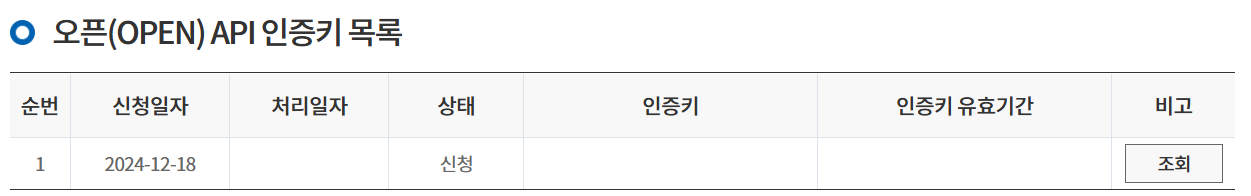

온통청년 (https://www.youthcenter.go.kr/youngPlcyUnif/youngPlcyUnifList.do) 크롤링 하기로 결정

### 2) 크롤링

**라이브러리 불러오기**

In [2]:
import requests
from bs4 import BeautifulSoup as bs
import re
import pickle
import json
import os

**json,pickle 저장 및 불러오기 함수 정의**

In [3]:
def save_pickle(path: str, file_name: str, data: list):
    """
    데이터를 pickle 파일로 저장.
    """
    os.makedirs(path, exist_ok=True)
    with open(f"{path}/{file_name}", "wb") as f:
        pickle.dump(data, f)

def load_pickle(path: str) -> list:
    """
    pickle 파일에서 데이터 불러오기.
    """
    with open(path, "rb") as f:
        return pickle.load(f)

def save_json(path: str, file_name: str, data: list):
    """
    데이터를 json 파일로 저장.
    """
    os.makedirs(path, exist_ok=True)
    with open(f"{path}/{file_name}", "w", encoding="utf-8") as f:
        json.dump(data, f, indent=4, ensure_ascii=False)

def load_json(path: str) -> list:
    """
    json 파일에서 데이터 불러오기.
    """
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)


**정책 ID 크롤링**
- 목록 정렬: 1 페이지 - 60개 정책, 총 59 페이지.
- 정책 모집 현황은 '진행중','상시','신청 마감'으로 3가지. `24년 12월 23일 기준`으로 `상시`, `진행중`인 정책들만 추출.
   ```
    <div class="badge">
      <span class="label green">진행중</span>
      <span class="cate">주거분야</span>
    </div>
    ```
- 각 정책의 링크가 아래와 같이 구성. id 부분에서 `dtlLink_`를 제외한 부분이 각 정책의 코드번호.
  ```
   <a href="#"id="dtlLink_R2024011018628"onclick="f_Detail('R2024011018628');"class="tit">청년 주택드림 청약통장</a>
   ```
- 1 페이지부터 59 페이지까지 각 페이지에 있는 정책들의 id만 list로 추출.


In [4]:
def get_ids_with_state(page_num: int, url: str) -> list:
    """
    청년 정책의 ID 수집.
    Parameters:
        page_num (int): 추출하려는 총 페이지 수
        url (str): 추출 대상의 페이지 링크를 조합할 베이스 링크
    Returns:
        policy_id_list (list): 상시, 진행중인 정책의 ID를 list로 모아 반환합니다.
    """
    policy_id_list = []
    for i in range(1, page_num + 1):
        response = requests.get(f"{url}{i}")
        soup = bs(response.text, "lxml")
        
        badges = soup.select("div.badge")
        titles = soup.select("a.tit")
        organ = soup.select("div.organ-name")
        
        for j in range(len(titles)):
            badge = badges[j].find("span", attrs={"label"}).text
            if badge in ["진행중", "상시"]:
                policy_id = titles[j].attrs["id"].replace("dtlLink_", "")
                organ_name = re.sub(r"<.*?>", "", str(organ[j].select_one("p")))
                organ_name = "세종" if organ_name == "세종 세종" else organ_name
                if policy_id not in policy_id_list:
                    policy_id_list.append([policy_id, organ_name])
    
    return policy_id_list


**정책 상세 정보 크롤링**
- index

| index | name               | index | name                     |
| ----- | ------------------ | ----- | ------------------------ |
| 0     | "정책 번호"        | 13    | "추가 단서 사항"         |
| 1     | "정책 분야"        | 14    | "참여 제한 대상"         |
| 2     | "지원 내용"        | 15    | "신청 절차"              |
| 3     | "사업 운영 기간"   | 16    | "심사 및 발표"           |
| 4     | "사업 신청청 기간" | 17    | "신청 사이트"            |
| 5     | "지원 규모(명)"    | 18    | "제출 서류"              |
| 6     | "비고"             | 19    | "기타 유익 정보"         |
| 7     | "연령"             | 20    | "주관 기관"              |
| 8     | "거주지 및 소득"   | 21    | "운영 기관"              |
| 9     | "학력"             | 22    | "사업관련 참고 사이트 1" |
| 10    | "전공"             | 23    | "사업관련 참고 사이트 2" |
| 11    | "취업 상태"        | 24    | "첨부파일"               |
| 12    | "특화 분야"        |


**HTML 문자열 처리 함수 정의**
- '객체.text'로 추출되지 않는 요소들이 존재. -> '객체.contents'로 개별 요소 추출.
- 요소에 `<br/>`이 있는 경우 이 현상이 잘 나타남. -> `<br/>`태그 제거
- '객체.text'로 추출한 경우 과도한 공백 및 줄바꿈 발견
- '객체.contents'로 추출할 경우 과도한 공백 및 줄바꿈을 이스케이프 문자로 추출 -> `\n, \t`등 이스케이프 문자 제거
- 여기서 과도한 공백이란 두 칸 이상의 띄어쓰기를 한 경우. 전체 띄어쓰기를 한 칸으로 맞추려면 시간이 오래 소요되기 때문에 두 칸만 제거.

In [5]:
def formated(string: str) -> str:
    """
    HTML 태그, 이스케이프 문자, 과도한 공백 제거.
    """
    tag_format = r"<.*?>"
    string = string.replace("\n", "").replace("\t", "")
    string = re.sub(tag_format, "", str(string))
    string = string.replace("  ", "")
    return string

In [6]:
def crawling(policy_id_list: list, url: str, params: dict, cont_attrs: bool = True) -> list:
    """
    정책 상세 정보를 수집.
    """
    total_policy = []
    format = {"br": r"<br/>", "a": r"<a href"}
    
    for id, organ in policy_id_list:
        policy = {}
        try:
            response = requests.get(f"{url}{id}")
        except:
            response = requests.get(f"{url.replace('https', 'http')}{id}")
        
        soup = bs(response.text, "html.parser")

        # 정책 이름 추출
        title = soup.find(params["title"][0], params["title"][1]).text
        policy["정책 이름"] = title
        
        if cont_attrs:
            policy["기관"] = organ
            subtitle = soup.find("p", "doc_desc").text
            subtitle = subtitle.replace("\r", " ")
            subtitle = subtitle.strip()
            policy["요약"] = subtitle
            list_tit = soup.find_all(
                name=params["list_tit"][0], attrs=params["list_tit"][1]
            )
            list_cont = soup.find_all(
                name=params["list_cont"][0], attrs=params["list_cont"][1]
            )
        else:
            list_tit = soup.find_all(name=params["list_tit"][0])
            list_cont = soup.find_all(name=params["list_cont"][0])
        
        # 항목 내용 처리
        for i in range(len(list_tit)):
            # list_cont[i].contents = ["\n", "ㅁㅁㅁ", "\n"] 또는 ["\n\t\t\t\tㅁㅁㅁㅁ\n\t\t\t\t", "<br/>", "ㅁㅁㅁ"]과 같이 나옴
            if len(list_cont[i].contents) > 1:
                contents = []
                for j in range(len(list_cont[i].contents)):
                    content = list_cont[i].contents[j]
                    # <br/> 제거
                    if re.match(format["br"], str(content)) != None:
                        content = None
                    # url만 있는 경우 추출
                    elif re.match(format["a"], str(content)) != None:
                        content = content.attrs["href"]
                    # 그 외 공백 제거, '\n', '\t', 제거 안된 html 태그 제거
                    else:
                        content = content.text
                        content = content.strip()
                        content = formated(content)
                    # 처리 작업이 끝난 후 의미있는 요소만 contents(list)에 추가
                    if content not in [None, "\n", "", ","]:
                        # \r이 있을 경우 이를 구분자로 분할한 뒤 삽입
                        if "\r" in content:
                            content = content.split("\r")
                            for con in content:
                                contents.append(con)
                        else:
                            contents.append(content)
                if len(contents) == 1:
                    contents = "".join(contents)
            else:
                contents = list_cont[i].contents
                contents = "".join(contents)
                contents = formated(contents)

            # 동일한 요소가 contents(list)에 들어있을 경우
            if (
                isinstance(contents, list)
                and len(contents) == 2
                and contents[0] == contents[1]
            ):
                contents = set(contents)
                contents = "".join(contents)
                contents = formated(contents)
            # 정책의 항목 이름, 내용 연결
            policy[list_tit[i].text] = contents
        total_policy.append(policy)
    return total_policy

**main 코드**
- 해당 웹 사이트 크롤링

In [39]:
# 저장 경로 생성
DATA_DIR = "../data"
os.makedirs(DATA_DIR, exist_ok=True)

# 정책 ID 수집
URL = "https://www.youthcenter.go.kr/youngPlcyUnif/youngPlcyUnifList.do?pageUnit=60&pageIndex="
policy_id_list = get_ids_with_state(59, URL)
print(f"{len(policy_id_list)}개 정책 ID 크롤링 완료")

# 저장
save_pickle(f"{DATA_DIR}", "policy_id_list.pkl", policy_id_list)
print("policy_id_list 저장 완료")

# 정책 상세 정보 크롤링
DETAIL_URL = "https://www.youthcenter.go.kr/youngPlcyUnif/youngPlcyUnifDtl.do?bizId="
params = {
    "title": ["h2", "doc_tit01 type2"],
    "list_tit": ["div", "list_tit"],
    "list_cont": ["div", "list_cont"],
}
total_policy = crawling(policy_id_list, DETAIL_URL, params, cont_attrs=True)
print(f"{len(total_policy)}개 정책 상세 정보 크롤링 완료")

# 저장
save_json(f"{DATA_DIR}", "policy.json", total_policy)
print("policy.json 저장 완료")


1337개 정책 ID 크롤링 완료
policy_id_list 저장 완료
1337개 정책 상세 정보 크롤링 완료
policy.json 저장 완료


# 02. 데이터 전처리

### 1) 데이터 구조화

**사용되지 않을 항목 삭제**
- key값이 아래에 해당하면 항목 삭제
  >["요약", "정책 번호", "신청 사이트", "사업관련 참고 사이트 1", "사업관련 참고 사이트 2", "첨부파일"]


**의미 없는 값 삭제**
- value값이 아래에 해당하면 항목 삭제
  >["제한없음", "", "-", "상관없음", "□제한없음","□ 제한없음","- 제한없음","-제한없음"]

In [30]:
# 삭제 항목 정의
remove_keys = [
    "요약", "정책 번호", "신청 사이트", 
    "사업관련 참고 사이트 1", "사업관련 참고 사이트 2", "첨부파일"
]

remove_values = [
    "제한없음", "", "-", "상관없음", "□제한없음",
    "□ 제한없음","- 제한없음","-제한없음"
]

# 삭제 함수 정의
def remove_keys_from_data(data, keys):
    if isinstance(data, list):
        return [remove_keys_from_data(item, keys) for item in data]
    elif isinstance(data, dict):
        return {
            key: remove_keys_from_data(value, keys)
            for key, value in data.items()
            if key not in keys
        }
    else:
        return data

def remove_values_from_data(data):
    if isinstance(data, list):
        return [remove_values_from_data(item) for item in data if item not in remove_values]
    elif isinstance(data, dict):
        return {
            key: remove_values_from_data(value)
            for key, value in data.items()
            if value not in remove_values
        }
    else:
        return data
    
# 불러오기 
data = load_json("../data/policy.json")

# 삭제
data_cleaned_keys = remove_keys_from_data(data, remove_keys)
preprocess_data = remove_values_from_data(data_cleaned_keys)

# 저장
save_json("../data","policy_result.json", preprocess_data)

print("policy_result.json 저장 완료")

policy_result.json 저장 완료


### 2) 텍스트 전처리

**불용어 삭제**
- 문서에서 `100번 이상` 등장한 단어를 frequent_words 리스트에 저장
- 리스트에서 불용어로 판단 되는 것들 추출
- 성능 평가 후 성능 최적화를 위해 삭제하는 단어를 변경할 수 있음
- 불용어 리스트
  > "수행", "경우", "해당", "통하여", "대한", "관련", "연", "있는", "자", "기준",
    "시", "가능", "신청", "등", "및", "확인", "포함", "또는", "중인",
    "후", "심사", "통해", "따라", "서비스", "제공", "프로그램", "참여", "따른",
    "단", "추가", "중", "수", "맞춤형", "대한", "해당", "관한", "이용", "그",
    "개별", "등을", "두고"

In [14]:
import json
import re
from collections import Counter

# 불러오기
data = load_json("../data/policy.json")

# 모든 텍스트 추출
def text_from_json(data):
    """
    JSON 데이터에서 모든 문자열을 추출.
    """
    texts = []
    if isinstance(data, dict):
        for value in data.values():
            texts.extend(text_from_json(value))
    elif isinstance(data, list):
        for item in data:
            texts.extend(text_from_json(item))
    elif isinstance(data, str):
        texts.append(data)
    return texts

# 단어 분리
def text_to_word(text):
    """
    텍스트를 정제하고 단어 단위로 분리.
    """
    text = re.sub(r'[^가-힣a-zA-Z0-9\s]', '', text)  # 특수문자 제거
    words = text.split()  # 공백 기준으로 단어 분리
    return words

# 자주 등장하는 단어 찾기
def get_frequent_words(words, threshold=100):
    """
    단어 목록에서 자주 등장하는 단어를 찾음.
    """
    word_counts = Counter(words)
    frequent_words = [word for word, count in word_counts.items() if count >= threshold]
    return frequent_words

# 실행
if __name__ == "__main__":

    # 불러오기
    FILE_PATH = "../data/policy_result.json"
    data = load_json(FILE_PATH)
    
    # 텍스트 추출
    texts = text_from_json(data)
    
    # 단어 분리
    all_words = []
    for text in texts:
        all_words.extend(text_to_word(text))
    
    # 50번 이상 등장하는 단어
    threshold = 100
    frequent_words = get_frequent_words(all_words, threshold)
    
    # 출력
    print("[100번 이상 등장하는 단어]")
    for i in range(0, len(frequent_words), 10):
        print(", ".join(frequent_words[i:i + 10]))


[100번 이상 등장하는 단어]
청년, 주거분야, 최대, 연, 있는, 자, 기준, 월, 경우, 1년
이상, 가입, 시, 이하, 주택, 출산, 2024년, 12월31일, 가능, 만
19세, 34세, 소득, 매월, 지원, 2024, 2, 대상, 신청, 중위소득
등, 및, 확인, 제외, 포함, 거주, 별도, 또는, 중인, 후
온라인, 방문, 월세, 지급, 신청서, 서류, 사본, 사업, 심사, 통해
고용노동부, 일자리분야, 1, 따라, 서비스, 제공, 기간, 프로그램, 참여, 위한
취업, 따른, 단, 1회, 추가, 상시, 중, 수, 6개월, 이내
필요한, 1인, 가구, 문의, 대상자, 동의서, 제출, 신청인이, 관련, 증빙서류
3, 4, 5, 3개월, 보건복지부, 복지문화분야, 맞춤형, 지역, 참고, 대한
모두, 해당, 배우자, 현재, 관한, 홈페이지, 관할, 선정, 기타, 주민등록상
동일, 이용, 불가, 그, 신분증, 주민등록등본, 지원내용, 창업, 필수, 1인당
미만, 각, 개별, 지원사업, 18세, 이후, 39세, 공고문, 20241231, 본인
주소지, 거주지, 읍면동, 행정복지센터, 예산, 참조, 발급, 기업, 등을, 모집
서울, 운영, 교육, 서울시, 신혼부부, 신청자, 작성, 접수, 내용, 주관기관과
12, 상담, 신청일, 두고, 신청방법, 내, 지원대상, 거주하는, 임차인, 교육분야
30만원, 사업장, 사업자, 소상공인, 통한, 지원금, 면접, 사업기간, 참여자, 미정
경기, 공고, 이메일, 경북, 경기도, 1부, 북구, 동구, 남구, 관내
울산광역시, 보증료, 울산


**url 삭제**
- 정규표현식이 'http://'(http,https),'.kr'인 경우 url이라고 판단하고 삭제  

**특수기호 삭제**
- 숫자, 한글, 영어를 제외하고 삭제
- 소수점 유지를 위해 '.'은 유지

In [31]:
import re

# 불러오기
data = load_json("../data/policy_result.json")

# 불용어 
stopwords = [
    "수행", "경우", "해당", "통하여", "대한", "관련", "연", "있는", "자", "기준",
    "시", "가능", "신청", "등", "및", "확인", "포함", "또는", "중인",
    "후", "심사", "통해", "따라", "서비스", "제공", "프로그램", "참여", "따른",
    "단", "추가", "중", "수", "맞춤형", "대한", "해당", "관한", "이용", "그",
    "개별", "등을", "두고"
]

# 제거 함수
def remove_text(text):
    if isinstance(text, str):
        # URL 제거
        text = re.sub(r'\bhttps?://[^\s]*\.kr\b', '', text)
        
        # 특수기호 제거 (숫자, 한글, 영어 유지)
        text = re.sub(r'[^가-힣a-zA-Z0-9\s.]',' ', text)
        
        # 불용어 제거
        for stopword in stopwords:
            text = text.replace(stopword, '')
        return text   
    
    return text

# 데이터 처리
def process_json(data):
    if isinstance(data, dict):
        return {key: process_json(value) for key, value in data.items()}
    elif isinstance(data, list):
        return [process_json(item) for item in data]
    elif isinstance(data, str):
        return remove_text(data)
    else:
        return data


cleaned_data = process_json(data)

# 저장
save_json("../data","policy_result.json",cleaned_data)
print("policy_result.json 저장 완료")

policy_result.json 저장 완료


### 3) 토큰화


In [33]:
import json
import re

# 불러오기
data = load_json("../data/policy_result.json")

# 문자열 정제 (불용어 제거 없음)
def clean_text(text: str):
    """
    텍스트 정제 (불용어 제거 없음)
    """
    if isinstance(text, str):
        # URL 제거
        text = re.sub(r'\bhttps?://[^\s]*\.kr\b', '', text)
        
        # 특수기호 제거 (숫자, 한글, 영어, 공백 유지)
        text = re.sub(r'[^가-힣a-zA-Z0-9\s]', ' ', text)
        
        # 다중 공백 제거
        text = " ".join(text.split()).strip()
        
        return text
    return text

# 키-값을 문자열로 병합
def key_value_to_string(key, value):
    """
    키와 값을 병합하여 문자열로 반환
    """
    merged_value = merge_values(value)
    return f"{key}:{merged_value}"

# 리스트, 딕셔너리, 문자열 병합
def merge_values(item):
    """
    리스트, 딕셔너리, 문자열을 하나의 문자열로 병합
    """
    if isinstance(item, list):
        return " ".join(merge_values(sub_item) for sub_item in item)
    elif isinstance(item, dict):
        return " ".join(f"{key}:{merge_values(value)}" for key, value in item.items())
    elif isinstance(item, str):
        return clean_text(item)
    else:
        return str(item)

# 정책 이름을 키로 사용하고 나머지 키-값을 리스트로 변환
def tokenize_by_policy_name(data):
    """
    정책 이름을 키로 사용하고, 나머지 키-값을 리스트로 변환합니다.
    """
    result = {}
    if isinstance(data, list):
        for item in data:
            if isinstance(item, dict) and "정책 이름" in item:
                policy_name = item["정책 이름"]
                
                # 나머지 키-값을 리스트로 변환
                tokenized_content = [
                    key_value_to_string(key, value)
                    for key, value in item.items()
                    if key != "정책 이름"
                ]
                
                result[policy_name] = tokenized_content
    return result
tokenized_data = tokenize_by_policy_name(data)
# 저장
save_json("../data","policy_result.json",tokenized_data)
print("policy_result.json 저장 완료")



policy_result.json 저장 완료


# 03. RAG 시스템

# 04. 성능 평가